# Lecture 5: Decision Trees, Random Forests, and Boosting

In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
#this import is new
from sklearn import tree
# this import is new
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import numpy as np
import pandas as pd

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Let's read in the "Hitters" dataset from ISLR that has information on baseball players, their stats, and their salaries.  Also, we'll drop any rows with missing values.

In [5]:
hitters = pd.read_csv("./hitters.csv")
hitters = hitters.dropna(inplace=False)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We'll get rid of a few categorical columns rather than deal with converting them.  Then we'll create a binary variable for whether a player makes more than the median salary.

In [6]:
X_df = hitters.drop(["Salary", "League", "Division", "NewLeague"], axis=1)
X = np.array(X_df)
y = (hitters["Salary"] >= np.median(hitters["Salary"])).astype("int")

Let's make the usual train/test split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Next, we'll train a scikit-learn classification [decision tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) using the "gini" splitting criterion.  We could also have selected the "entropy" criterion.  Here's the documentation for the scikit-learn regression [decision tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), which splits based on MSE.

In [8]:
dt = tree.DecisionTreeClassifier(criterion="gini", min_samples_split=10)
dt.fit(X_train, y_train)

dt_test_preds = dt.predict_proba(X_test)[:, 1]
dt_test_preds

array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.66666667,  0.        ,  1.        ,
        0.66666667,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  0.        ,  0.5       ,  0.        ,  0.66666667,
        0.        ,  1.        ,  0.11111111,  0.        ,  0.        ,
        0.        ,  1.        ,  0.66666667,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.11111111,  1.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.        ,  0.11

There are several different ways to control the tree structure in the all of the scikit-learn tree classes.  Usually you would select just one of them:
- `max_depth`: the number of layers deep to grow the tree (decision tree and random forest go as deep as possible by default; gradient boosting goes 3 deep)
- `min_samples_split`: don't continue to split an internal node if there are fewer than this many examples in the node; the default is 2, i.e. always keep splitting
- `min_samples_leaf`: don't consider something a leaf node if it has more than this many examples; default is 1
- `max_leaf_nodes`: maximum number of final leaf nodes; default is None, i.e. as many as we can get

In [9]:
fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(y_test, dt_test_preds)

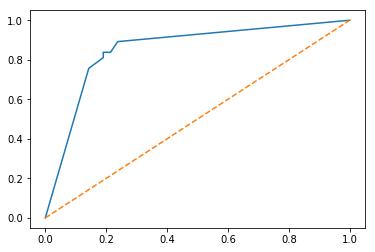

In [10]:
# we want to draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

plt.plot(fpr_decision_tree, tpr_decision_tree)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [11]:
roc_auc_score(y_test, dt_test_preds)

0.85263835263835264

Note that the scikit-learn decision tree doesn't do pruning like R does, so you should read through the lab in the book to see the R code for doing that.

Let's visualize the tree that we've grown.  For this to work, you have to install [graphviz](http://www.graphviz.org/Download..php) with `conda install graphviz` and then do `pip install pydotplus`.

In [36]:
from sklearn.externals.six import StringIO  
import pydotplus
dot_data = StringIO() 
tree.export_graphviz(dt, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("./hitters.pdf") 

True

In [37]:
X_df.columns[3]

'Runs'

## The Decision Boundary of a Decision Tree

Let's build a model off of only two predictors, `Walks` and `Hits` so that we visualize the decision boundary.  That is, how is the tree partitioning up the two-dimensional space.

In [38]:
X_2 = np.array(hitters[["Walks", "Hits"]])
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y, train_size=0.7)

dt.fit(X_2_train, y_2_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

As we've done before with k-NN and logistic regression, we'll make a two-dimensional grid and get the model prediction at each point, and then color the plane by the prediction.

In [39]:
# step size of the mesh
h = 20
# range of the mesh
x_min, x_max = X_2[:, 0].min() - .5, X_2[:, 0].max() + .5
y_min, y_max = X_2[:, 1].min() - .5, X_2[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [40]:
# ravel is the same as reshape(-1)
all_preds = dt.predict(np.column_stack((xx.ravel(), yy.ravel())))
grid_preds = all_preds.reshape(xx.shape)

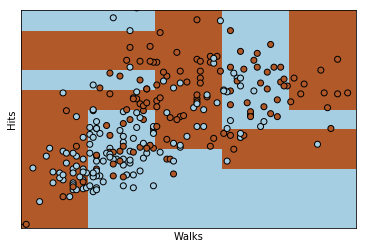

In [41]:
plt.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired)

plt.scatter(X_2[:, 0], X_2[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Walks')
plt.ylabel('Hits')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Random Forests

scikit-learn also has an easy-to-use random forest [classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

The parameter `n_estimators` controls how many different trees we want to fit, each one on a bootstrap sampled version of the dataset.  The parameter `max_features` controls how many of the different predictors we consider splitting on at each node.  `n_jobs` means that we can split the training up over multiple cores to make it faster.  And `oob_score` tells it to save the out-of-bag scores for each example.

In [42]:
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,
                            n_jobs=4, verbose=0)

In [43]:
rf.fit(X_train, y_train)

rf_test_preds = rf.predict_proba(X_test)[:, 1]
rf_test_preds

array([ 0.775,  0.968,  0.999,  0.73 ,  0.   ,  0.827,  0.025,  0.49 ,
        0.003,  0.91 ,  0.347,  0.712,  0.016,  0.017,  0.024,  0.518,
        0.015,  0.001,  0.8  ,  0.991,  0.893,  0.001,  0.031,  0.98 ,
        1.   ,  0.9  ,  0.001,  0.462,  0.   ,  0.802,  0.012,  0.978,
        0.34 ,  0.012,  0.898,  0.012,  0.916,  0.908,  0.892,  0.003,
        0.479,  0.038,  0.002,  0.004,  0.008,  0.996,  0.93 ,  0.02 ,
        0.558,  0.818,  0.   ,  0.002,  0.656,  0.64 ,  0.951,  0.005,
        0.626,  0.513,  0.13 ,  0.991,  0.567,  0.064,  0.016,  0.01 ,
        0.5  ,  0.784,  0.994,  0.991,  0.647,  0.577,  0.018,  0.826,
        0.939,  0.6  ,  0.551,  0.997,  0.004,  0.707,  0.195])

In [45]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_test_preds)

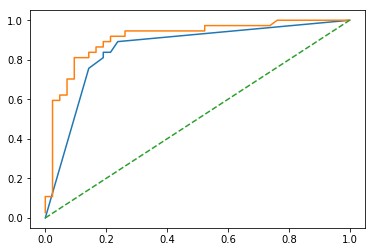

In [46]:
plt.plot(fpr_decision_tree, tpr_decision_tree)
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [47]:
roc_auc_score(y_test, rf_test_preds)

0.91023166023166024

random forests and gradient boosting tree ensembles have a metric that tells us how important different features are.  This comes from adding up the decrease in error each time that predictor is used as a split.

In [48]:
rf_importances = rf.feature_importances_
rf_importances

array([ 0.03122109,  0.04429896,  0.02226923,  0.03481047,  0.03988324,
        0.02063832,  0.040302  ,  0.12423257,  0.15419144,  0.04777455,
        0.15268745,  0.1150086 ,  0.1150334 ,  0.02583758,  0.0158362 ,
        0.01597491])

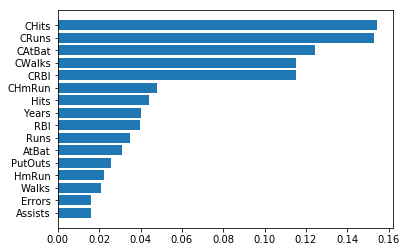

In [49]:
# we get the indices in the order that would make the importances sorted
sorted_indices = np.argsort(rf_importances)

y_pos = range(len(rf_importances))
plt.barh(y_pos, rf_importances[sorted_indices], align='center')
plt.yticks(y_pos, X_df.columns[sorted_indices])
plt.show()

We can get the accuracy on the out-of-bag examples:

In [50]:
rf.oob_score_

0.84239130434782605

And the out-of-bag scores for the training examples themselves:

In [51]:
rf.oob_decision_function_

array([[ 0.11979167,  0.88020833],
       [ 0.33711048,  0.66288952],
       [ 1.        ,  0.        ],
       [ 0.03234501,  0.96765499],
       [ 0.38309859,  0.61690141],
       [ 0.6028169 ,  0.3971831 ],
       [ 0.9942029 ,  0.0057971 ],
       [ 0.54177898,  0.45822102],
       [ 0.24565757,  0.75434243],
       [ 0.1142132 ,  0.8857868 ],
       [ 0.40217391,  0.59782609],
       [ 0.99401198,  0.00598802],
       [ 0.37437186,  0.62562814],
       [ 0.47076023,  0.52923977],
       [ 1.        ,  0.        ],
       [ 0.01453488,  0.98546512],
       [ 0.97660819,  0.02339181],
       [ 0.95039164,  0.04960836],
       [ 0.99453552,  0.00546448],
       [ 0.15151515,  0.84848485],
       [ 0.69680851,  0.30319149],
       [ 0.05982906,  0.94017094],
       [ 0.98901099,  0.01098901],
       [ 0.0778098 ,  0.9221902 ],
       [ 0.01917808,  0.98082192],
       [ 1.        ,  0.        ],
       [ 0.50135501,  0.49864499],
       [ 0.06303725,  0.93696275],
       [ 0.72702703,

As we saw last week, we can use the `GridSearchCV` function to do a scan over the tuneable parameters of the random forest to get the best values.

In [52]:
param_grid = {"n_estimators": [1, 10, 100, 500],
              "max_depth": [1, 2, 5, None],
              "max_features": ['sqrt', 'auto']
             }

cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=4, refit=True)
cv.fit(X_train, y_train)

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/e

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/e

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/e

/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/envs/civis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/civisemployee/anaconda3/e

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=4, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [1, 10, 100, 500], 'max_depth': [1, 2, 5, None], 'max_features': ['sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [54]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

The most important parameter is the number of trees:

In [55]:
cv.grid_scores_

[mean: 0.85870, std: 0.04202, params: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 1},
 mean: 0.85870, std: 0.03317, params: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 10},
 mean: 0.86413, std: 0.03154, params: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.85870, std: 0.04202, params: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500},
 mean: 0.82609, std: 0.05600, params: {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 1},
 mean: 0.85870, std: 0.04202, params: {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 10},
 mean: 0.86413, std: 0.03154, params: {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 100},
 mean: 0.86957, std: 0.03351, params: {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 500},
 mean: 0.80978, std: 0.06673, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1},
 mean: 0.85870, std: 0.06013, params: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10},

In [56]:
# step size of the mesh
h = 20
# range of the mesh
x_min, x_max = X_2[:, 0].min() - .5, X_2[:, 0].max() + .5
y_min, y_max = X_2[:, 1].min() - .5, X_2[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [57]:
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, max_features='sqrt',
                            n_jobs=1, verbose=0)
rf.fit(X_2_train, y_2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [58]:
# ravel is the same as reshape(-1)
all_preds = rf.predict(np.column_stack((xx.ravel(), yy.ravel())))
grid_preds = all_preds.reshape(xx.shape)

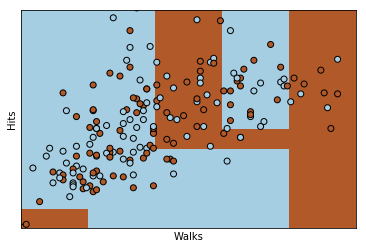

In [59]:
plt.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired)

plt.scatter(X_2_train[:, 0], X_2_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Walks')
plt.ylabel('Hits')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Boosting

Next, let's look at the gradient boosting [classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (there's also a gradient boosting [regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).)

Like random forets, the `n_estimators` parameter controls how many trees we want to fit.  The `learning_rate` parameter controls how slowly we want the classifier to learn.  Typically, the smaller the value of the learning rate the more trees you'll need.

In [60]:
gbt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_depth=3)

In [61]:
gbt.fit(X_train, y_train)

gbt_test_preds = gbt.predict_proba(X_test)[:, 1]
gbt_test_preds

array([  9.97828516e-01,   9.98561162e-01,   9.99951531e-01,
         9.74254516e-01,   2.22524432e-04,   9.68955289e-01,
         1.03307421e-04,   2.36097926e-01,   1.07033843e-03,
         9.96860893e-01,   6.62983750e-02,   9.31174273e-01,
         3.44540839e-04,   1.57639586e-04,   1.30696795e-03,
         1.03641893e-01,   7.87230023e-04,   3.43949570e-04,
         9.70608504e-01,   9.99625133e-01,   9.92781051e-01,
         6.34091879e-04,   1.14141621e-03,   9.99585867e-01,
         9.99917948e-01,   9.80432687e-01,   5.21234477e-04,
         4.09470246e-01,   4.87451569e-04,   7.96700965e-01,
         8.84723502e-04,   9.97717851e-01,   3.53260124e-01,
         1.25244259e-03,   9.87024354e-01,   9.34922587e-04,
         9.96363303e-01,   9.50564538e-01,   9.97469865e-01,
         9.33824465e-05,   1.66861355e-01,   3.75292393e-04,
         3.11791592e-04,   1.70371175e-04,   5.23113786e-04,
         9.99912154e-01,   9.97857695e-01,   1.25244259e-03,
         4.15070793e-01,

In [62]:
fpr_gbt, tpr_gbt, thresholds_gbt = roc_curve(y_test, gbt_test_preds)

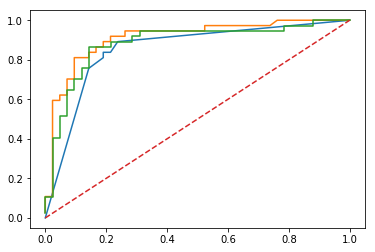

In [63]:
plt.plot(fpr_decision_tree, tpr_decision_tree)
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_gbt, tpr_gbt)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [64]:
roc_auc_score(y_test, rf_test_preds)

0.91023166023166024

In [ ]:
gbt_importances = gbt.feature_importances_
sorted_indices = np.argsort(gbt_importances)

y_pos = range(len(gbt_importances))
plt.barh(y_pos, gbt_importances[sorted_indices], align='center')
plt.yticks(y_pos, X_df.columns[sorted_indices])
plt.show()

GBT has a `staged_predict` function that shows you what prediction it would make after each tree in the ensemble sum.

In [ ]:
num_trees = []
train_errs = []
for i, y_pred in enumerate(gbt.staged_predict(X_train)):
    num_trees.append(i)
    train_errs.append(zero_one_loss(y_train, y_pred))
    
test_errs = []
for i, y_pred in enumerate(gbt.staged_predict(X_test)):
    test_errs.append(zero_one_loss(y_test, y_pred))

In [ ]:
plt.plot(num_trees, train_errs)
plt.plot(num_trees, test_errs)
plt.xlabel("Number of Trees")
plt.xlabel("Error")
plt.show()

[This](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html) is probably a better example of what this plot would look like on a bigger dataset.

I don't have time to go into these, but **[partial dependence plots](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html)** are a great way to visualize what's happening in a regression problem with tree ensembles.

## Extra Random Trees

Amazingly, just taking random predictors and random split thresholds, rather than choosing the best ones, does a great job.  That's what the extra random trees [classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and [regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) do.  Why would you ever want to do this??  It's blazingly fast because you don't have to check which predictors and which values to split on.  You just take random ones!!

In [ ]:
et = ExtraTreesClassifier(n_estimators=500, n_jobs=1)

In [ ]:
et.fit(X_train, y_train)

et_test_preds = et.predict_proba(X_test)[:, 1]
et_test_preds

In [ ]:
fpr_et, tpr_et, thresholds_et = roc_curve(y_test, et_test_preds)

In [ ]:
plt.plot(fpr_decision_tree, tpr_decision_tree)
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_gbt, tpr_gbt)
plt.plot(fpr_et, tpr_et)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [ ]:
roc_auc_score(y_test, et_test_preds)

In [ ]:
et = ExtraTreesClassifier(n_estimators=1000, n_jobs=1)
et.fit(X_2_train, y_2_train)

In [ ]:
# ravel is the same as reshape(-1)
all_preds = et.predict(np.column_stack((xx.ravel(), yy.ravel())))
grid_preds = all_preds.reshape(xx.shape)

In [ ]:
plt.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired)

plt.scatter(X_2_train[:, 0], X_2_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Walks')
plt.ylabel('Hits')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()